In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os 
import requests
import json

load_dotenv()

TEAM_DIRECTORY = "2024/teams"
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')

In [ ]:
# PULL LATEST GITHUB VERSIONS OF CSV FILES
def get_latest_release(owner, repo, file_name):
    url = f"https://api.github.com/repos/{owner}/{repo}/releases"
    headers = {
        "Authorization": f"token {GITHUB_TOKEN}",
        "Accept": "application/vnd.github.v3+json"
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        releases = response.json()
        
        if not releases:
            print(f"No releases found for {owner}/{repo}")
            return None, None
            
        for release in releases:
            for asset in release.get('assets', []):
                if asset.get('name') == file_name:
                    return asset.get('updated_at'), asset.get('browser_download_url')
        
        print(f"File {file_name} not found in any release")
        return None, None
        
    except requests.exceptions.RequestException as e:
        print(f"Error accessing GitHub API: {e}")
        return None, None

def pull_latest_csv(year):
    owner = "nflverse"
    repo = "nflverse-data"
    file_name = f"play_by_play_{year}.csv"
    output_file_name = f"Raw_Data/{file_name}"
    
    update_date, download_url = get_latest_release(owner, repo, file_name)
    
    if download_url is None:
        print(f"Could not find the file {file_name} in releases")
        return None
        
    success = download_release(download_url, output_file_name)
    if not success:
        print("Failed to download file")
        return None
        
    try:
        df = pd.read_csv(output_file_name, low_memory=False)
        df = add_id(df)
        df = fix_stats(df)
        df.to_csv(output_file_name)
    except Exception as e:
        print(f"Error processing CSV file: {e}")
        return None

def download_release(download_url, file_name):
    try:
        directory = os.path.dirname(file_name)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
            
        response = requests.get(download_url)
        response.raise_for_status()
        
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file_name} successfully.")
        return True
        
    except Exception as e:
        print(f"Error in download_release: {e}")
        return False

In [3]:
df = pd.read_csv("Raw_Data/play_by_play_2024.csv", low_memory=False)
teams = df['posteam'].dropna().unique()
del(df)

In [18]:
# Sort plays into team files
def create_team_folders(year):
    team_directory = f"{year}/teams"
    df = pd.read_csv(f"Raw_Data/play_by_play_{year}.csv", low_memory=False)

    for team in teams:
        team_dir = os.path.join(team_directory, team)
        os.makedirs(team_dir)

        # make offense & defense
        team_offense_file = os.path.join(team_dir, "offense.csv")
        team_defense_file = os.path.join(team_dir, "defense.csv")
        
        offense_df = df[df['posteam'] == team]
        offense_df.to_csv(team_offense_file, index=False)
        
        # For defense
        defense_df = df[df['defteam'] == team]
        defense_df.to_csv(team_defense_file, index=False)

create_team_folders("2024")

In [ ]:
# Team records
df = pd.read_csv("Raw_Data/play_by_play_2024.csv", low_memory=False)

record = {}

for team in teams:
    record[team] = [0, 0, 0] # [win, loss, tie]

    weeks_played = df[df['posteam'] == team].week.unique()
    
    for week in weeks_played:
        home_team = df[(df['posteam'] == team) & (df['week'] == week)]['home_team'].unique()
        away_team = df[(df['posteam'] == team) & (df['week'] == week)]['away_team'].unique()
        home_score = df[(df['posteam'] == team) & (df['week'] == week)]['home_score'].unique()
        away_score = df[(df['posteam'] == team) & (df['week'] == week)]['away_score'].unique()

        if (home_team == team and home_score > away_score) or (away_team == team and away_score > home_score):
            record[team][0] += 1 # Win
        elif (home_team == team and home_score < away_score) or (away_team == team and home_score > away_score):
            record[team][1] += 1 # Loss
        else:
            record[team][2] += 1 # Tie

In [78]:
# Early down eff (1st down > 3 second down > 50%)

# QB Kneel & Qb Spike are also 'valid' but for efficiency metrics we dont care about those
valid_plays = ['pass', 'run'] 

team_early_down = {}

for team in teams:
    team_early_down[team] = [0, 0, 0, 0] # 1st down eff plays, 2nd down eff plays, tot 1, tot 2

for team in os.listdir(TEAM_DIRECTORY):
    team_dir = os.path.join(TEAM_DIRECTORY, team, 'offense.csv')
    team_df = pd.read_csv(team_dir)

    for _, play in team_df.iterrows():
        # Check if it is a valid play 
        if play['play_type'] in valid_plays:
            if play['down'] == 1:
                team_early_down[team][2] += 1
                if play['yards_gained'] >= 3:
                    team_early_down[team][0] += 1
            if play['down'] == 2:
                team_early_down[team][3] += 1

                togo = play['ydstogo']
                half_togo = togo/2 
                
                if play['yards_gained'] > half_togo:
                    team_early_down[team][1] += 1

team_early_down_efficiency = {}

for team in teams:
    team_early_down_efficiency[team] = [
        (team_early_down[team][0]/team_early_down[team][2]) * 100, 
        (team_early_down[team][1]/team_early_down[team][3]) * 100, 
        ((team_early_down[team][0] + team_early_down[team][1]) / (team_early_down[team][2] + team_early_down[team][3])) * 100] # [1st down eff, 2nd down eff, early down(1st & 2nd)]

print(team_early_down_efficiency)


{'ARI': [62.878787878787875, 56.770833333333336, 60.30701754385965], 'BUF': [55.59440559440559, 56.42201834862385, 55.952380952380956], 'BAL': [62.65822784810127, 54.46428571428571, 59.25925925925925], 'KC': [64.13043478260869, 52.702702702702695, 59.036144578313255], 'NO': [59.64912280701754, 47.59825327510917, 54.280155642023345], 'CAR': [56.79012345679012, 44.32432432432433, 51.4018691588785], 'DAL': [55.32786885245902, 49.21465968586388, 52.643678160919535], 'CLE': [51.8796992481203, 43.89140271493213, 48.25462012320328], 'SEA': [55.78947368421052, 50.24875621890548, 53.49794238683128], 'DEN': [60.854092526690394, 46.788990825688074, 54.70941883767535], 'GB': [61.09090909090909, 53.80952380952381, 57.938144329896915], 'PHI': [58.718861209964416, 50.23696682464455, 55.08130081300813], 'IND': [53.4965034965035, 42.28855721393035, 48.870636550308014], 'HOU': [49.122807017543856, 41.6289592760181, 45.8498023715415], 'MIA': [57.608695652173914, 48.07692307692308, 53.51239669421488], 'JA

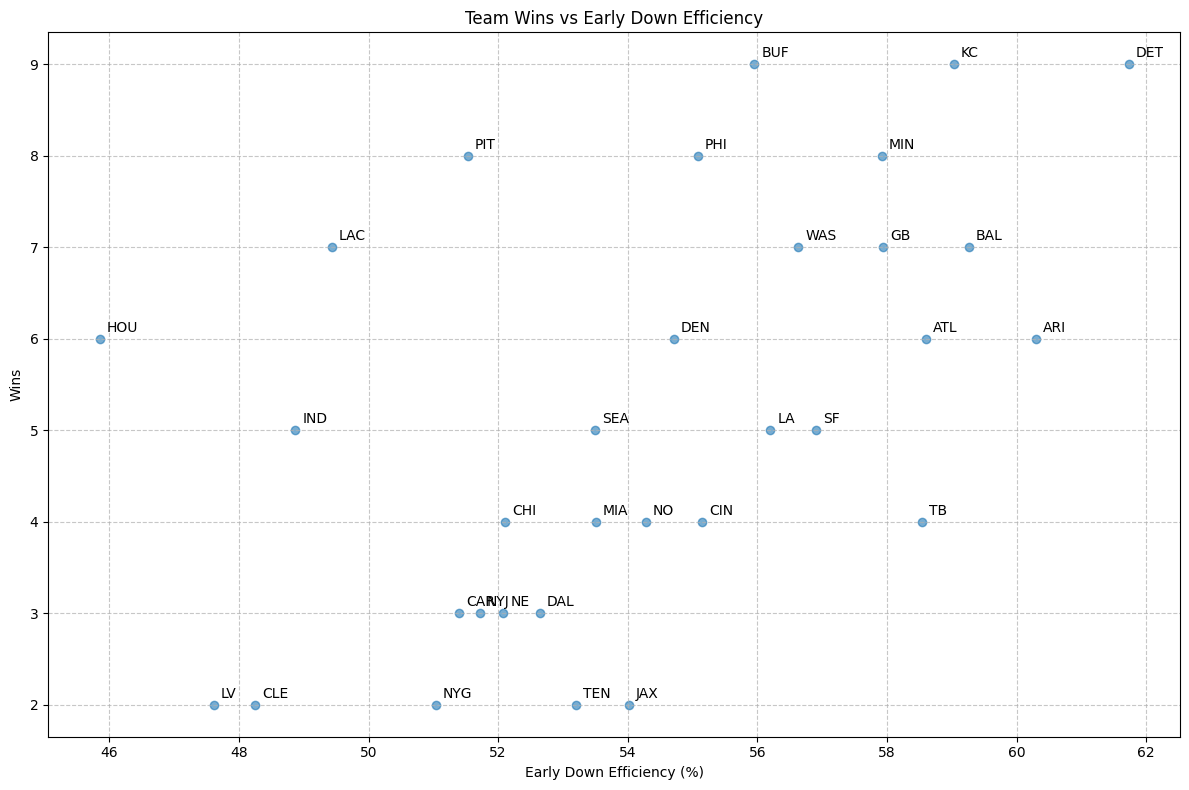

In [89]:
# Viz

team_eff = []
team_wins = []
team_label = []

for team in teams:
    team_eff.append(team_early_down_efficiency[team][2])
    team_wins.append(record[team][0])
    team_label.append(team)

plt.figure(figsize = (12, 8))
plt.scatter(team_eff, team_wins, alpha = 0.6)

for i, team in enumerate(team_label):
    plt.annotate(team, (team_eff[i], team_wins[i]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('Early Down Efficiency (%)')
plt.ylabel('Wins')
plt.title('Team Wins vs Early Down Efficiency')

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [22]:
# Early game explosiveness -> offensive success 

scores = {}
yards = {}

for team in teams:
    team_dir = os.path.join(TEAM_DIRECTORY, team, 'offense.csv')
    df = pd.read_csv(team_dir)

    weeks = df.week.unique()
    
    for week in weeks:
        quarter_one_df = df[(df.week == week) & (df.qtr == 1)]
        
        explosive_plays = {
            'ten_plus': sum(quarter_one_df.yards_gained >= 10),
            'twenty_plus': sum(quarter_one_df.yards_gained >= 20)
        }
            
        is_home = quarter_one_df.home_team.iloc[0] == team
        score = quarter_one_df.home_score.iloc[-1] if is_home else quarter_one_df.away_score.iloc[-1]
        yards_gained = df[df['week'] == week].yards_gained.sum()

        if score not in scores:
            scores[score] = []
        
        if yards_gained not in yards:
            yards[yards_gained] = []

        scores[score].append([explosive_plays['ten_plus'], explosive_plays['twenty_plus']])
        yards[yards_gained].append([explosive_plays['ten_plus'], explosive_plays['twenty_plus']])
    

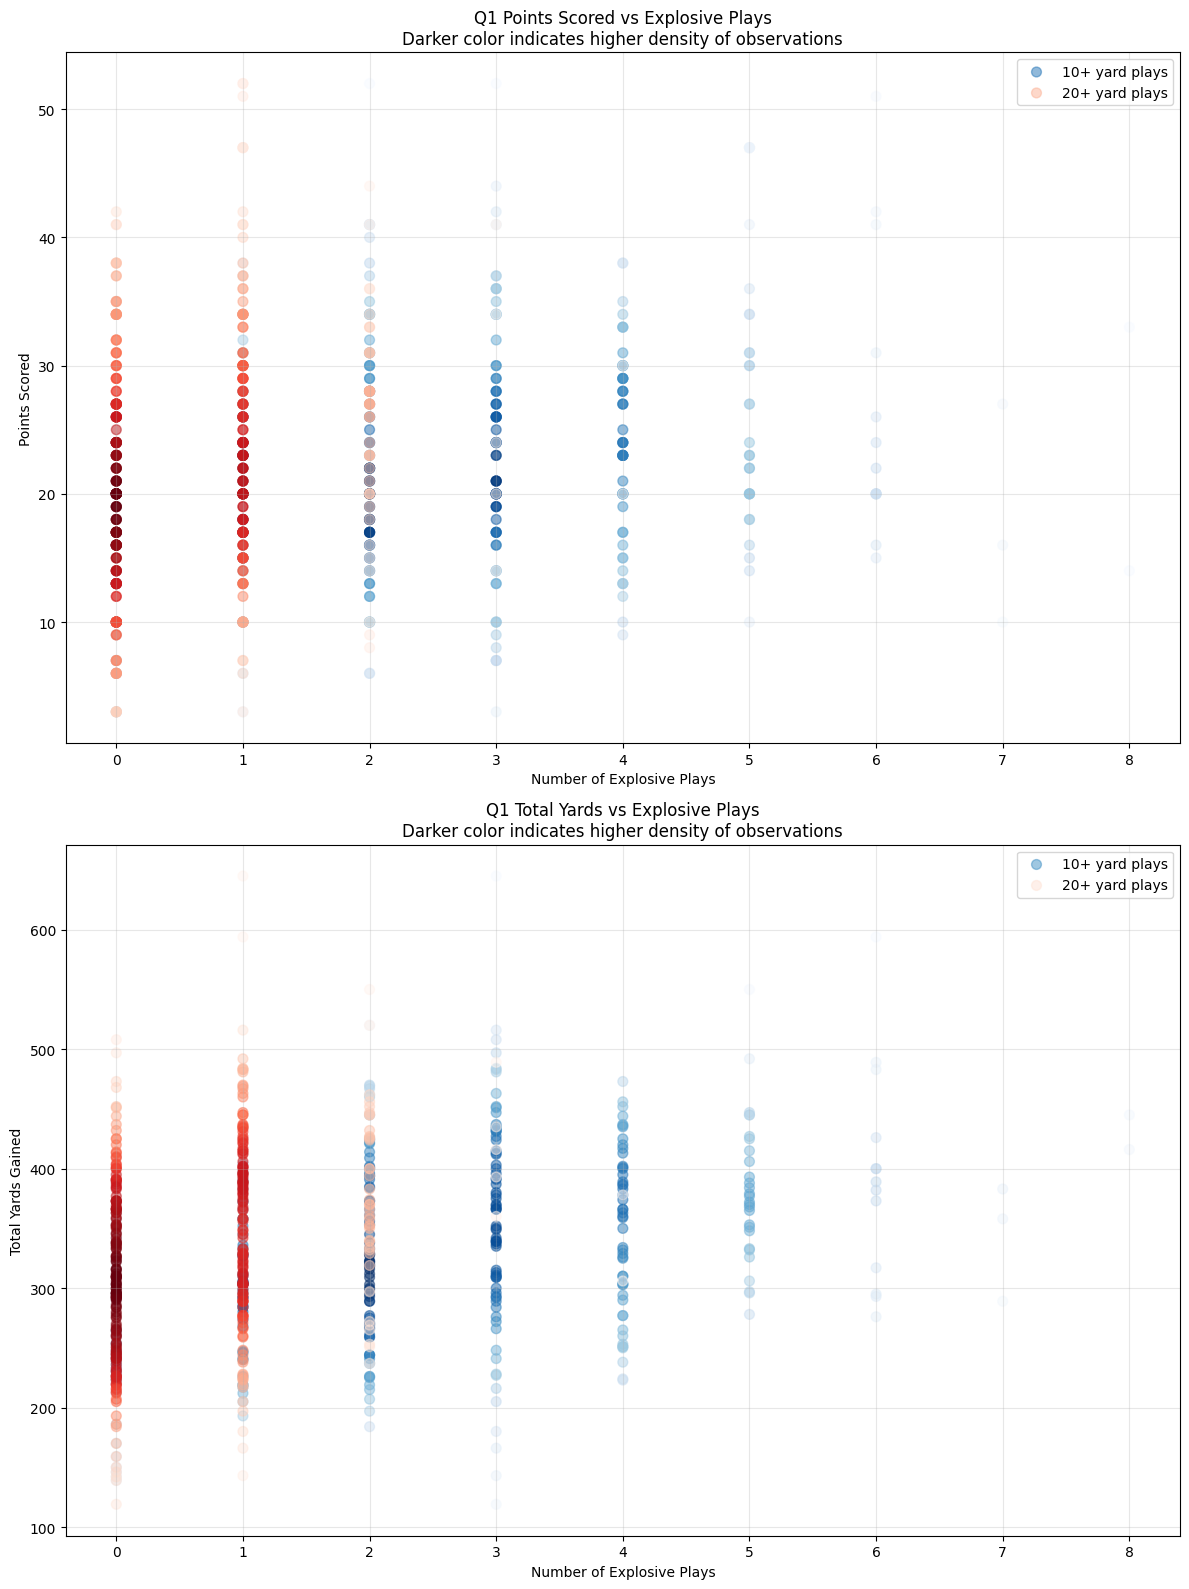

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def create_explosive_plays_plots(scores, yards):
    # Create a figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Plot 1: Explosive Plays vs Scores
    x_10plus = []  # Will store number of 10+ yard plays
    x_20plus = []  # Will store number of 20+ yard plays
    y_scores = []  # Will store points for each observation
    
    for score, plays in scores.items():
        plays_array = np.array(plays)
        # For each score, add the number of 10+ yard plays and the score
        x_10plus.extend(plays_array[:, 0])
        # For each score, add the number of 20+ yard plays and the score
        x_20plus.extend(plays_array[:, 1])
        # Add the score for each observation
        y_scores.extend([score] * len(plays_array))
    
    # Convert to numpy arrays
    x_10plus = np.array(x_10plus)
    x_20plus = np.array(x_20plus)
    y_scores = np.array(y_scores)
    
    # Calculate the point density for both types of plays
    xy_10plus = np.vstack([x_10plus, y_scores])
    z_10plus = gaussian_kde(xy_10plus)(xy_10plus)
    
    xy_20plus = np.vstack([x_20plus, y_scores])
    z_20plus = gaussian_kde(xy_20plus)(xy_20plus)
    
    # Plot with both scatter and density
    scatter1_10 = ax1.scatter(x_10plus, y_scores, c=z_10plus, s=50, alpha=0.5, 
                            cmap='Blues', label='10+ yard plays')
    scatter1_20 = ax1.scatter(x_20plus, y_scores, c=z_20plus, s=50, alpha=0.5, 
                            cmap='Reds', label='20+ yard plays')
    
    ax1.set_ylabel('Points Scored')
    ax1.set_xlabel('Number of Explosive Plays')
    ax1.set_title('Q1 Points Scored vs Explosive Plays\nDarker color indicates higher density of observations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Explosive Plays vs Total Yards
    x_yards_10plus = []
    x_yards_20plus = []
    y_total_yards = []
    
    for total_yards, plays in yards.items():
        plays_array = np.array(plays)
        x_yards_10plus.extend(plays_array[:, 0])
        x_yards_20plus.extend(plays_array[:, 1])
        y_total_yards.extend([total_yards] * len(plays_array))
    
    # Convert to numpy arrays
    x_yards_10plus = np.array(x_yards_10plus)
    x_yards_20plus = np.array(x_yards_20plus)
    y_total_yards = np.array(y_total_yards)
    
    # Calculate the point density
    xy_yards_10plus = np.vstack([x_yards_10plus, y_total_yards])
    z_yards_10plus = gaussian_kde(xy_yards_10plus)(xy_yards_10plus)
    
    xy_yards_20plus = np.vstack([x_yards_20plus, y_total_yards])
    z_yards_20plus = gaussian_kde(xy_yards_20plus)(xy_yards_20plus)
    
    # Plot with both scatter and density
    scatter2_10 = ax2.scatter(x_yards_10plus, y_total_yards, c=z_yards_10plus, s=50, 
                            alpha=0.5, cmap='Blues', label='10+ yard plays')
    scatter2_20 = ax2.scatter(x_yards_20plus, y_total_yards, c=z_yards_20plus, s=50, 
                            alpha=0.5, cmap='Reds', label='20+ yard plays')
    
    ax2.set_ylabel('Total Yards Gained')
    ax2.set_xlabel('Number of Explosive Plays')
    ax2.set_title('Q1 Total Yards vs Explosive Plays\nDarker color indicates higher density of observations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Example usage:
fig = create_explosive_plays_plots(scores, yards)
plt.show()

In [ ]:
# Momentum of drives

consecutive_5 = {}
pass_attempts = {}

for team in teams:
    team_dir = os.path.join(TEAM_DIRECTORY, team, 'offense.csv')
    df = pd.read_csv(team_dir)

    for week in df.week.unique():
        4
    